In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
import multivariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer


In [2]:
df_2015 = pd.read_csv(data_path+"2015-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)
df_2016 = pd.read_csv(data_path+"2016-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)

print("In 2015 data :", df_2015.shape[0],
      " buildings and ", df_2015.shape[1],"variables")
print("Total NaNs = ", df_2015.isna().sum().sum(), 
      "(that is ",np.round(100*df_2015.isna().sum().sum()/(
        df_2015.shape[0]*df_2015.shape[1]),2), "%)")

In 2015 data : 3340  buildings and  47 variables
Total NaNs =  26512 (that is  16.89 %)


# Data merge : 

I decided to merge the 2016 and 2015 dataframes, taking the mean value if the building is in both.

In [113]:
data = pd.merge(df_2016, df_2015, on ="OSEBuildingID" ,
               how = 'outer', suffixes=('', '_2015'))

def my_agg_by_mean(colname):
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res.mean(axis=1)
        data.drop(colname, axis=1, inplace=True)
    return(data)        
    
def my_agg_filling_missing(colname) :
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res[colname[:-5]].fillna(colname)
        data.drop(colname, axis=1, inplace=True)
    return(data)
    
float_var = data.loc[:,data.dtypes==float].columns.values
int_var = data.loc[:,data.dtypes==int].columns.values
all_num_var = np.concatenate((float_var,int_var))

for colname in all_num_var:
    data = my_agg_by_mean(colname)
for colname in data.columns :
    data = my_agg_filling_missing(colname)

data.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'PropertyName', 'Address', 'City', 'State', 'ZipCode',
       'TaxParcelIdentificationNumber', 'CouncilDistrictCode', 'Neighborhood',
       'Latitude', 'Longitude', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'YearsENERGYSTARCertified', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
       'NaturalGas(kBtu)', 'DefaultData', 'Comments', 'ComplianceStatus',
       'Outlier

# Variable type : 
First of all, it is essential to know what variable is relevant for my study. I used the graphical histogram or sorted plot of the variable serie, and I compared that to [the original page on Seattle data website](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) to determine what type each variable is. It allowed me to separate numerical, categorical and identification variable :  

array([1. , 2. , 2.5, 3. , 4. , 5. , 5.5, 6. , 7. ])

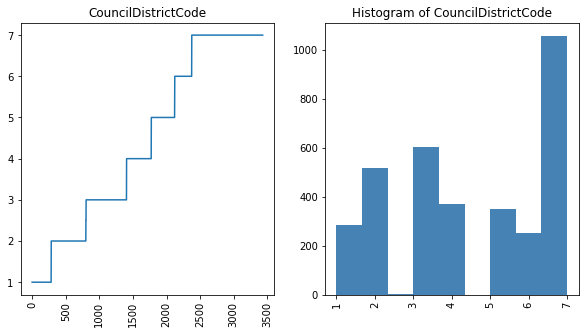

In [103]:
var = "CouncilDistrictCode"
univariate_analysis.repartition_and_hist(data,var)
np.unique(data[var])

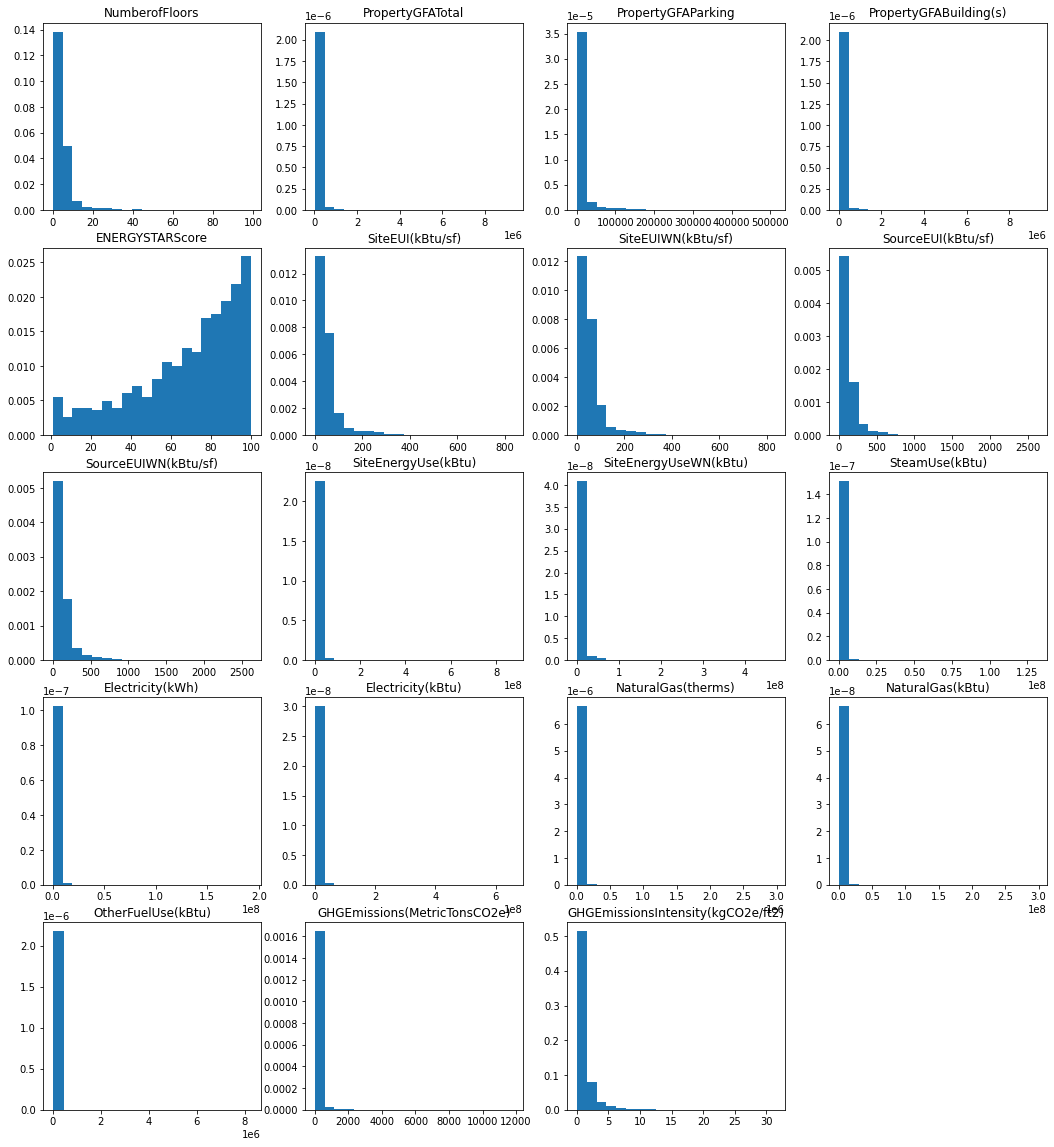

In [104]:
univariate_analysis.plot_multi_hist(data, numerical_var)

In [114]:
##### univariate_analysis.plot_multi_hist(data, categorical_var, figsize=(20,10))
# data = df_2015
# data["BuildingType"] = data["BuildingType"].astype("category", copy=False)
# for var in categorical_var :
#     print(var)
#     univariate_analysis.plot_hist_y(data[var])
y = data["BuildingType"] 
np.unique(y.values)

array(['BuildingType_2015', 'Campus', 'Multifamily HR (10+)',
       'Multifamily LR (1-4)', 'Multifamily MR (5-9)', 'NonResidential',
       'Nonresidential COS', 'Nonresidential WA', 'SPS-District K-12'],
      dtype=object)

In [116]:

# data = df_2015.loc[:,np.append(all_num_var,"OSEBuildingID")]
# df_2015[categorical_var]
data[categorical_var].dtypes

CouncilDistrictCode                                              float64
2010 Census Tracts                                               float64
Seattle Police Department Micro Community Policing Plan Areas    float64
City Council Districts                                           float64
SPD Beats                                                        float64
Zip Codes                                                        float64
BuildingType                                                      object
PrimaryPropertyType                                               object
Neighborhood                                                      object
ComplianceStatus                                                  object
dtype: object

## Prétraitement 
Les types semblent corrects (vérifiés avec df.dtypes). 

##### Gestion des doublons :

In [206]:
data = df_2015.loc[:,np.append(np.array(float_var),"OSEBuildingID")]
dict_duplicates = preprocess.get_index_merge_duplicates(data, float_var, 1.15)
print(dict_duplicates)

{}


#####  Suppression colonnes vides :

In [207]:
##
## drop empty columns
##
data = df_2015.loc[:,float_var].set_index(df_2015["OSEBuildingID"])

nan_repartition = data.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.95)
data = missing_values_treatment.preprocess_drop_col_nan(data, nan_threshold)

print("I drop variables with less than", 
      data.shape[0]-np.floor(nan_threshold),
      "values")
print("That is more than", 
      np.floor(nan_threshold),
      "missing values")
print("I have dropped", len(float_var)- data.shape[1] + 2,
      "variables :",
      float_var[[var not in data.columns for var in float_var]])

I drop variables with less than 258.0 values
That is more than 3082.0 missing values
I have dropped 4 variables : ['2010 Census Tracts' 'City Council Districts']


In [208]:
float_var = data.columns[[var not in ["ENERGYSTARScore", "OSEBuildingID"] for var in data.columns]]
X = data[float_var]
y = data["ENERGYSTARScore"]


##### Inférence valeurs manquantes : 

MSE = 131.642 (+/-23.211) for {'n_neighbors': 1}
MSE = 116.114 (+/-13.146) for {'n_neighbors': 2}
MSE = 111.882 (+/-10.362) for {'n_neighbors': 3}
MSE = 110.496 (+/-10.746) for {'n_neighbors': 4}
MSE = 110.178 (+/-11.167) for {'n_neighbors': 5}
MSE = 110.570 (+/-11.347) for {'n_neighbors': 6}
MSE = 110.877 (+/-11.766) for {'n_neighbors': 7}
MSE = 111.173 (+/-11.955) for {'n_neighbors': 8}
MSE = 111.373 (+/-12.669) for {'n_neighbors': 9}
MSE = 111.522 (+/-13.120) for {'n_neighbors': 10}
MSE = 111.627 (+/-13.281) for {'n_neighbors': 11}
MSE = 111.866 (+/-13.065) for {'n_neighbors': 12}
MSE = 112.016 (+/-13.351) for {'n_neighbors': 13}
MSE = 112.140 (+/-13.771) for {'n_neighbors': 14}
MSE = 112.218 (+/-14.038) for {'n_neighbors': 15}
MSE = 112.370 (+/-14.009) for {'n_neighbors': 16}
MSE = 112.547 (+/-14.098) for {'n_neighbors': 17}
MSE = 112.621 (+/-13.980) for {'n_neighbors': 18}
MSE = 112.725 (+/-14.100) for {'n_neighbors': 19}
MSE = 112.934 (+/-14.236) for {'n_neighbors': 20}
MSE = 113

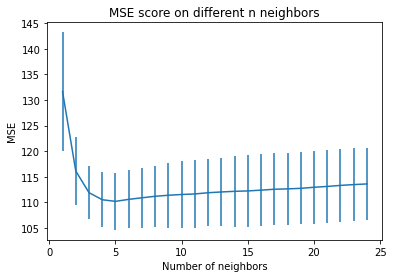

In [209]:
##
## Standardize X : 
##

standardizer = preprocessing.StandardScaler().fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)

# ##
# ## Set the best number of neighbors
# ##

my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,25,1)}
cv = 3

# res = missing_values_treatment.launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
# # Save dictionnary of results : 
# import pickle
# with open(res_path+"set_n_KNN_impute"+".pkl", "wb") as f :
#     pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

import pickle
with open(res_path+"set_n_KNN_impute"+".pkl", "rb") as f :
        res = pickle.load(f)

fig_name = "set_n_KNN_impute.jpg"
missing_values_treatment.plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

In [210]:
## Impute missing values :
imputer = KNNImputer(n_neighbors=4)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)


##### Retrait des bâtiments sans le score : 

In [211]:
index_to_drop = data[data["ENERGYSTARScore"].isna().values].index
data = data.drop(index_to_drop,axis=0)

X = data[float_var]
X_pred = pred.drop(index_to_drop,axis=0)
y = data["ENERGYSTARScore"]

## Etude des variables descriptives numériques

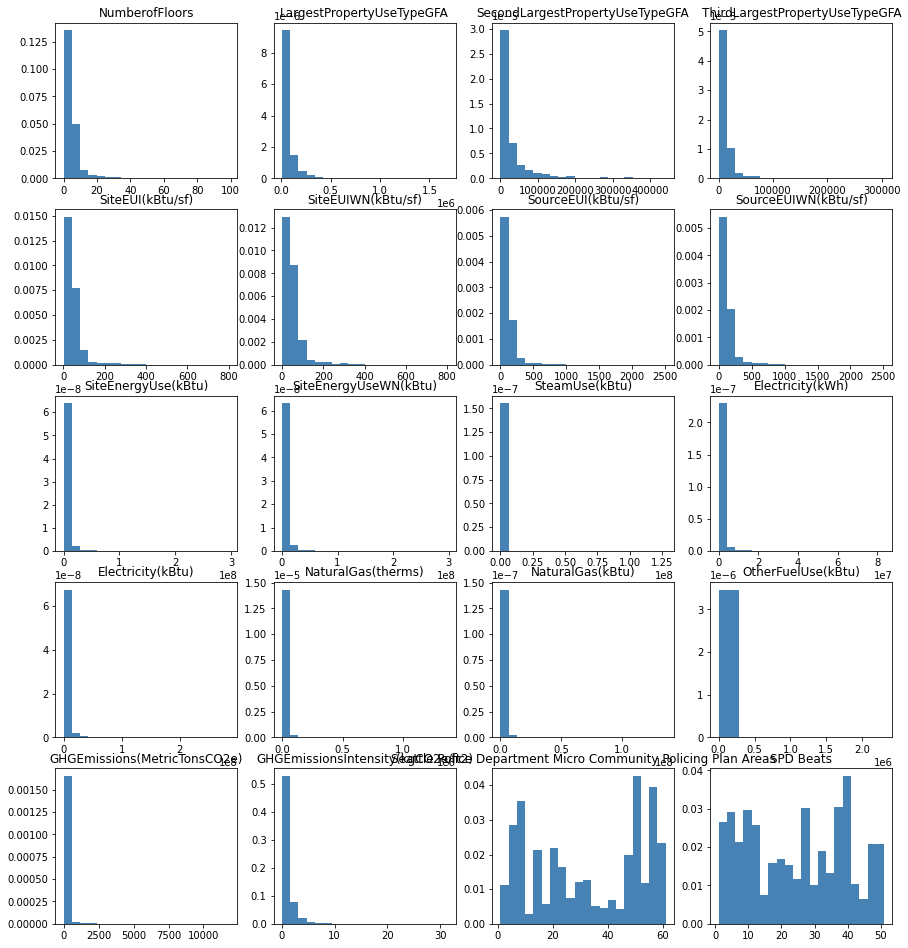

In [58]:
nb_line_plot = int(np.floor(len(float_var)/4)+1)
fig = plt.figure(figsize=(15, 20))

fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,4, fig_count)
    nb_bins = min(20, len(np.unique(data[var].dropna().values)))
    ax.hist(data[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

In [10]:
data["Seattle Police Department Micro Community Policing Plan Areas"]
data["SPD Beats"]

OSEBuildingID
1        31.0
2        31.0
3        31.0
5        31.0
8        31.0
         ... 
50049    16.0
50055    38.0
50057     7.0
50058    48.0
50059    48.0
Name: SPD Beats, Length: 2560, dtype: float64

## Etude de la variable de réponse 

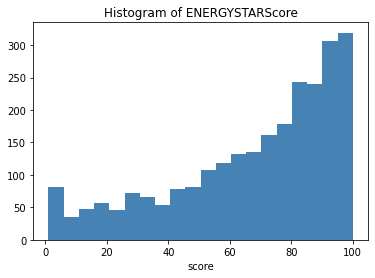

count    2560.000000
mean       67.894141
std        27.154057
min         1.000000
25%        51.750000
50%        76.000000
75%        90.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

In [11]:
import univariate_analysis

univariate_analysis.plot_hist_y(y)
    
y.describe()

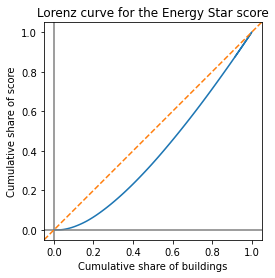

gini = 0.22380585297213407
AUC = 0.38809707351393297


In [11]:
univariate_analysis.plot_lorenz_curve(y)